In [1]:
import pandas as pd
from pathlib import Path
import re
import sympy
from datetime import datetime
import os

In [2]:
def convert_to_function_notation(equations):
    """Convert Derivative(S, t) to Derivative(S(t), t) in equations"""
    t = sympy.Symbol('t')

    result = []
    for eq in equations:
        # LHS
        if isinstance(eq.lhs, sympy.Derivative):
            var = eq.lhs.args[0]  # This is S, E, etc.
            if isinstance(var, sympy.Symbol):
                func_name = str(var)
                func = sympy.Function(func_name)
                new_lhs = sympy.Derivative(func(t), t)
            else:
                new_lhs = eq.lhs
        else:
            new_lhs = eq.lhs
        
        # RHS
        state_vars = ['S', 'E', 'I', 'P', 'A', 'H', 'R', 'F']
        subs_dict = {}
        for var_name in state_vars:
            var = sympy.Symbol(var_name)
            if var in eq.rhs.free_symbols:
                func = sympy.Function(var_name)
                subs_dict[var] = func(t)
        
        new_rhs = eq.rhs.subs(subs_dict)
        result.append(sympy.Eq(new_lhs, new_rhs))
    
    return result


#### AI setup

In [3]:
# check API key
import os

api_key = os.environ.get("OPENAI_API_KEY")
if api_key:
    print("API key is set")
else:
    print("API key not found in environment variables")

API key is set


In [4]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes, image_file_to_odes_str
client = OpenAIClient()

#### Extraction: image -> str

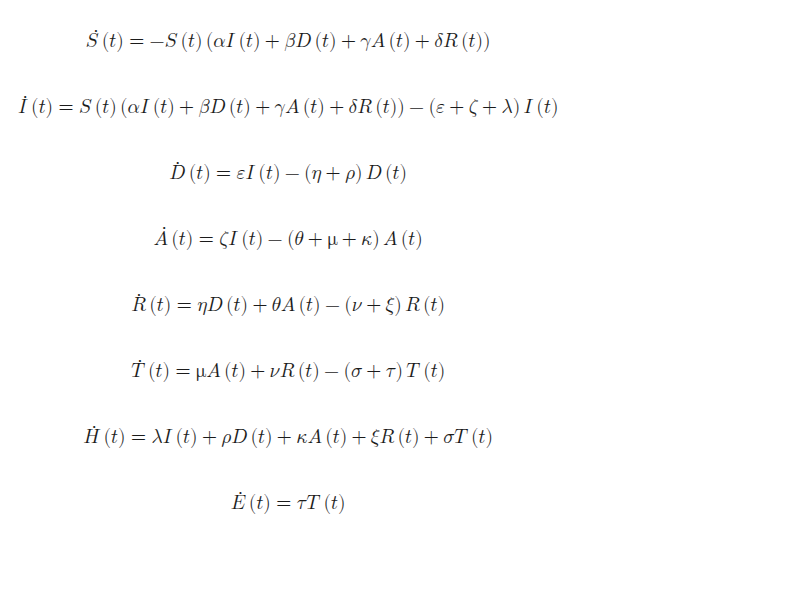

In [10]:
# Extract ODEs from image

biomodel_name = "BIOMD0000000955"

from IPython.display import Image
image_path = f'images/{biomodel_name}.png'
Image(image_path)

In [ ]:
from mira.sources.sympy_ode.llm_util import (
    run_multi_agent_pipeline,
    execute_template_model_from_sympy_odes
)

corrected_ode_str, corrected_concepts, evaluation = run_multi_agent_pipeline(
    image_path,
    client,
    verbose=True,
    biomodel_name=biomodel_name
)

MULTI-AGENT ODE EXTRACTION & VALIDATION PIPELINE

PHASE 1: ODE Extraction from Image


INFO: [2025-09-15 10:43:57] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  ODEs extracted from image
  Length: 1078 characters

PHASE 2: Concept Grounding


INFO: [2025-09-15 10:44:05] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  Extracted 8 concepts

PHASE 3: Execution Error Correction
  No execution errors found

PHASE 4: Validation Checks
  Running parameter and time-dependency validation...


INFO: [2025-09-15 10:44:09] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: [2025-09-15 10:44:13] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  Running mathematical validation...


INFO: [2025-09-15 10:44:24] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: [2025-09-15 10:44:35] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  Found 3 issue(s) to correct

PHASE 5: Unified Error Correction


INFO: [2025-09-15 10:44:41] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  Applied 3 correction(s)

PHASE 6: Quantitative Evaluation
  ODE executes successfully
  Execution Success Rate: 100%
  Symbol Accuracy Rate: 100.0%
  Overall Score: 100.00%
PIPELINE COMPLETE

Overall Score: 100.00%
Execution Success: 100%
Symbol Accuracy: 100.0%

Corrected ODEs:
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, I, D_variable, A, R, T, H_variable, E_variable = sympy.symbols("S I D A R T H E", cls=sympy.Function)

# Define the parameters
alpha, beta, gamma, delta, epsilon, zeta, lambda_param, eta, rho, theta, mu, nu, xi, sigma, tau, kappa = sympy.symbols("alpha beta gamma delta epsilon zeta lambda eta rho theta mu nu xi sigma tau kappa")

odes = [
    sympy.Eq(S(t).diff(t), - S(t) * (alpha * I(t) + beta * D_variable(t) + gamma * A(t) + delta * R(t))),
    sympy.Eq(I(t).diff(t), S(t) * (alpha * I(t) + beta * D_variable(t) + gamma * A(t) + delta * R(t)) - (epsilon + zeta + lambda_param) * I(t)),
    sympy.Eq(D_variable(

In [ ]:
# Results based on quantitative evaluation in the last phase of the multi-agent pipeline

print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"Overall Score: {evaluation['overall_score']:.2%}")
print(f"Execution Success: {evaluation['execution_success_rate']:.0%}")
print(f"Equation Accuracy: {evaluation['equation_accuracy_rate']:.1%}")
print(f"Equations Checked: {evaluation.get('num_equations_checked', 0)}")

# Display all comparison details
print("\n" + "="*60)
print("DETAILED EQUATION COMPARISON")
print("="*60)

if 'comparison_details' in evaluation and evaluation['comparison_details']:
    details = evaluation['comparison_details']
    
    # Count matches and mismatches
    matches = sum(1 for d in details if isinstance(d, dict) and d.get('match', False))
    mismatches = len(details) - matches
    
    print(f"Total Equations: {len(details)}")
    print(f"Matching: {matches}")
    print(f"Mismatched: {mismatches}")
    print("-"*60)
    
    # Print each equation comparison
    for i, detail in enumerate(details):
        if isinstance(detail, dict):
            print(f"\n[Equation {i}]")
            
            # Check if error occurred
            if 'error' in detail:
                print(f"  ERROR: {detail['error']}")
                continue
            
            # Print match status
            match_status = "✓ MATCH" if detail.get('match', False) else "✗ MISMATCH"
            print(f"  Status: {match_status}")
            
            # Print correct equation
            if 'correct' in detail:
                print(f"  Correct:   {detail['correct']}")
            
            # Print extracted equation
            if 'extracted' in detail:
                print(f"  Extracted: {detail['extracted']}")
            
            # Print difference (if mismatch)
            if not detail.get('match', False) and 'difference' in detail:
                diff_str = str(detail['difference'])
                # Truncate very long differences
                if len(diff_str) > 200:
                    diff_str = diff_str[:200] + "..."
                print(f"  Difference: {diff_str}")
else:
    print("No comparison details available.")
    print("Make sure the correct equations TSV file is accessible and contains this biomodel.")

print("\n" + "="*60)
print("CORRECTED ODE STRING")
print("="*60)
print(corrected_ode_str)


Overall Score: 100.00%
Execution Success: 100%


KeyError: 'equation_accuracy_rate'

In [12]:
tm = execute_template_model_from_sympy_odes(
    corrected_ode_str,
    corrected_concepts  
)

print("tm type:", type(tm))
print("tm has templates:", hasattr(tm, 'templates'))

# Check what's in the templates
print(f"Number of templates: {len(tm.templates)}")
print("\nTemplate details:")
for i, template in enumerate(tm.templates):
    print(f"\nTemplate {i}: {template.name if hasattr(template, 'name') else 'unnamed'}")
    print(f"  Type: {type(template)}")
    print(f"  Rate: {template.rate if hasattr(template, 'rate') else 'no rate'}")
    print(f"  Rate type: {type(template.rate) if hasattr(template, 'rate') else 'N/A'}")
    
    # Check for transitions (if this is a transition-based template)
    if hasattr(template, 'subject'):
        print(f"  Subject: {template.subject}")
    if hasattr(template, 'outcome'):
        print(f"  Outcome: {template.outcome}")
    if hasattr(template, 'consumed'):
        print(f"  Consumed: {template.consumed}")
    if hasattr(template, 'produced'):
        print(f"  Produced: {template.produced}")

tm type: <class 'mira.metamodel.template_model.TemplateModel'>
tm has templates: True
Number of templates: 17

Template details:

Template 0: None
  Type: <class 'mira.metamodel.templates.ControlledProduction'>
  Rate: no rate
  Rate type: N/A
  Outcome: name='H' display_name=None description=None identifiers={'ido': '0000511'} context={'status': 'hospitalized', 'species': 'ncbitaxon:9606'} units=None

Template 1: None
  Type: <class 'mira.metamodel.templates.NaturalDegradation'>
  Rate: no rate
  Rate type: N/A
  Subject: name='D' display_name=None description=None identifiers={'ido': '0000511'} context={'status': 'disease', 'species': 'ncbitaxon:9606'} units=None

Template 2: None
  Type: <class 'mira.metamodel.templates.NaturalDegradation'>
  Rate: no rate
  Rate type: N/A
  Subject: name='A' display_name=None description=None identifiers={'ido': '0000511'} context={'status': 'asymptomatic', 'species': 'ncbitaxon:9606'} units=None

Template 3: None
  Type: <class 'mira.metamodel.tem

In [13]:
from mira.modeling import Model
from mira.modeling.ode import OdeModel
om = OdeModel(Model(tm), initialized=True)
mtx_sympy = om.get_interpretable_kinetics()

mtx_odes_sympy = []
for i in range(mtx_sympy.shape[0]):
    lhs = mtx_sympy[i,0]
    rhs = mtx_sympy[i,2]
    mtx_odes_sympy.append(sympy.Eq(lhs, rhs))

mtx_odes_sympy = convert_to_function_notation(mtx_odes_sympy)


print("\nMatrix ODEs:")
for eq in mtx_odes_sympy:
    print(f"  {eq}")


Matrix ODEs:
  Eq(Derivative(A(t), t), zeta*I(t) - (kappa + mu + theta)*A(t))
  Eq(Derivative(H(t), t), D*rho + T*sigma + kappa*A(t) + lambda*I(t) + xi*R(t))
  Eq(Derivative(D(t), t), -D*(eta + rho) + epsilon*I(t))
  Eq(Derivative(T(t), t), -T*(sigma + tau) + mu*A(t) + nu*R(t))
  Eq(Derivative(R(t), t), D*eta - nu*R(t) + theta*A(t) - xi*R(t))
  Eq(Derivative(I(t), t), -(epsilon + lambda + zeta)*I(t) + (D*beta + alpha*I(t) + delta*R(t) + gamma*A(t))*S(t))
  Eq(Derivative(E(t), t), T*tau)
  Eq(Derivative(S(t), t), -(D*beta + alpha*I(t) + delta*R(t) + gamma*A(t))*S(t))


In [14]:
# Check the concepts
print('concept name\tidentifiers\tcontext')
for concept in tm.get_concepts_map().values():
    print(f'{concept.name}\t{concept.identifiers}\t{concept.context}')

concept name	identifiers	context
H	{'ido': '0000511'}	{'status': 'hospitalized', 'species': 'ncbitaxon:9606'}
A	{'ido': '0000511'}	{'status': 'asymptomatic', 'species': 'ncbitaxon:9606'}
D	{'ido': '0000511'}	{'status': 'disease', 'species': 'ncbitaxon:9606'}
T	{'ido': '0000592'}	{'status': 'transferred', 'species': 'ncbitaxon:9606'}
R	{'ido': '0000592'}	{'status': 'recovered', 'species': 'ncbitaxon:9606'}
I	{'ido': '0000511'}	{'status': 'infected', 'species': 'ncbitaxon:9606'}
E	{'apollosv': '00000154'}	{'status': 'exposed', 'species': 'ncbitaxon:9606'}
S	{'ido': '0000514'}	{'status': 'susceptible', 'species': 'ncbitaxon:9606'}
